# 0.0 IMPORTS

In [19]:
import math
import inflection
import random
import warnings
import pickle
import datetime
import requests
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



from boruta                import BorutaPy
from tabulate              import tabulate
from datetime              import datetime,timedelta
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1 Pre - Settings

In [20]:
# section function 7.2.1
def cross_validation(x_training,kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  
  for k in reversed(range(1, kfold+1)):
    if verbose:
      print('\nKfold Number: {}'.format(k))

    #start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

    # filtering dataset
    t = x_training[x_training['date']< validation_start_date]
    v = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    

    #training and validation

    #training
    xtraining = t.drop(['date','sales'],axis=1)
    ytraining = t['sales']

    #validation
    xvalidation = v.drop(['date','sales'],axis=1)
    yvalidation = v['sales']

    #model
    m = model.fit(xtraining, ytraining)

    #predict
    yhat = m.predict(xvalidation)

    #performace
    m_result= ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat))
    
    # store performace of each Kfolds iteration

    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                       'MAPE CV':  np.round(np.mean(mape_list),2).astype(str) + '+/-' +  np.round(np.std(mape_list),2).astype(str),
                       'RMSE CV':  np.round(np.mean(rmse_list),2).astype(str) + '+/-' +  np.round(np.std(rmse_list),2).astype(str)},index=[0])

# section function 7.0
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

# section function 7.0
def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# section function 4.1.3
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix() #cm confusion metrics  crosstab (Calcule uma tabulação cruzada simples de dois (ou mais) fatores)
    n = cm.sum()
    r, k = cm.shape  #número de linhas e colunas
    
    chi2 = ss.chi2_contingency( cm )[0]  #chi2 já tem método para calcular com scipy
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():

    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=10
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_options('display.expand_frame_repr',False )
    
    sns.set()

In [21]:
jupyter_settings()


AttributeError: module 'pandas' has no attribute 'set_options'

In [22]:
warnings.filterwarnings ('ignore')

## 0.2 Loading Data

In [37]:
#Loading datasets
df_sales_raw = pd.read_csv('./datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('./datasets/store.csv', low_memory=False)

    
#Merge
df_raw = pd.merge(df_sales_raw, df_store_raw)

In [38]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
28763,32,4,2015-04-09,3033,437,1,0,0,1,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0 DATA DESCRIPTIONS

## 1.1 Rename Columns

In [39]:
df1 = df_raw.copy()

In [40]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [41]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [46]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#Rename of columns
df1.columns = cols_new

## 1.1 Data Descriptions

In [47]:

print('Number rows: {}'.format(df1.shape[0]))
print('Number cols: {}'.format(df1.shape[1]))

Number rows: 1017209
Number cols: 18


## 1.2 Data Types

In [49]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [50]:
df1['date'] = pd.to_datetime(df1['date'],errors='coerce')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1. 4 Check NA

In [52]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA


In [54]:
df1['competition_distance'].max()

75860.0

In [55]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 

df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year       

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map']in x['promo_interval'].split(',') else 0 , axis=1)                 


In [56]:
df1.sample(5).T


,899670,228132,35207,285141,524216
store,987,251,39,314,575
day_of_week,1,3,3,1,6
date,2014-10-06 00:00:00,2013-01-30 00:00:00,2014-09-03 00:00:00,2013-12-09 00:00:00,2013-05-18 00:00:00
sales,9940,15501,6051,5408,2774
customers,1147,2129,775,659,255
open,1,1,1,1,1
promo,1,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,a,a,a


## 1.6 Change


In [58]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [60]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [61]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [63]:
## Separete #Separate categorical variables from numeric variables

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes=df1.select_dtypes(include = ['object'])

### 1.7.1 Numerical Attributes

In [66]:
#Central tendencian - mean, median

ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


<AxesSubplot:xlabel='competition_distance'>

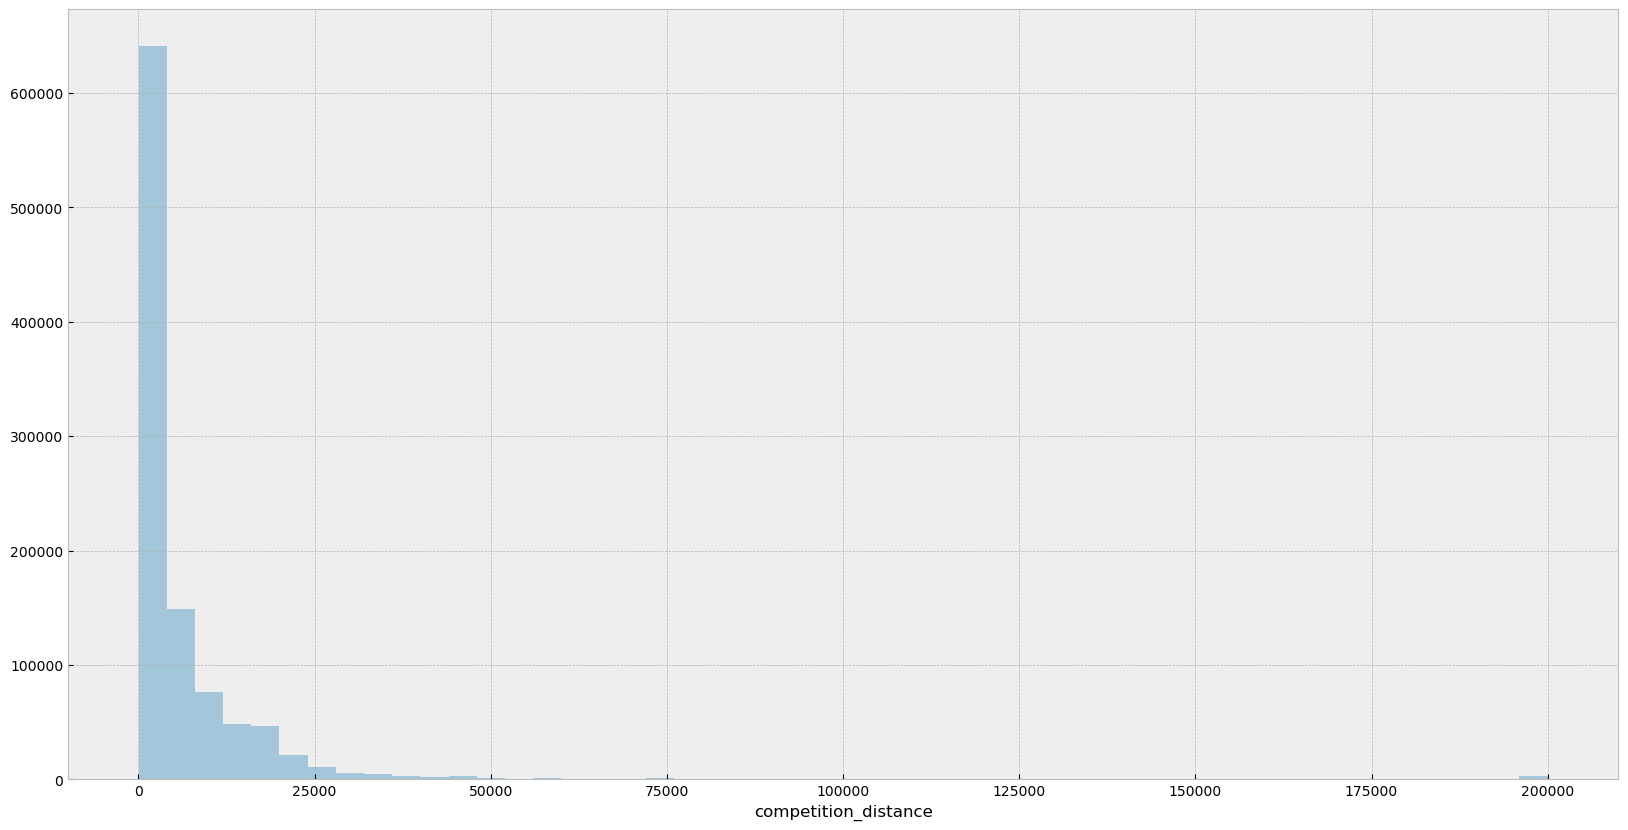

In [67]:
sns.distplot(df1['competition_distance'], kde= False)

### 1.7.2 Categorical Attributes

In [69]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

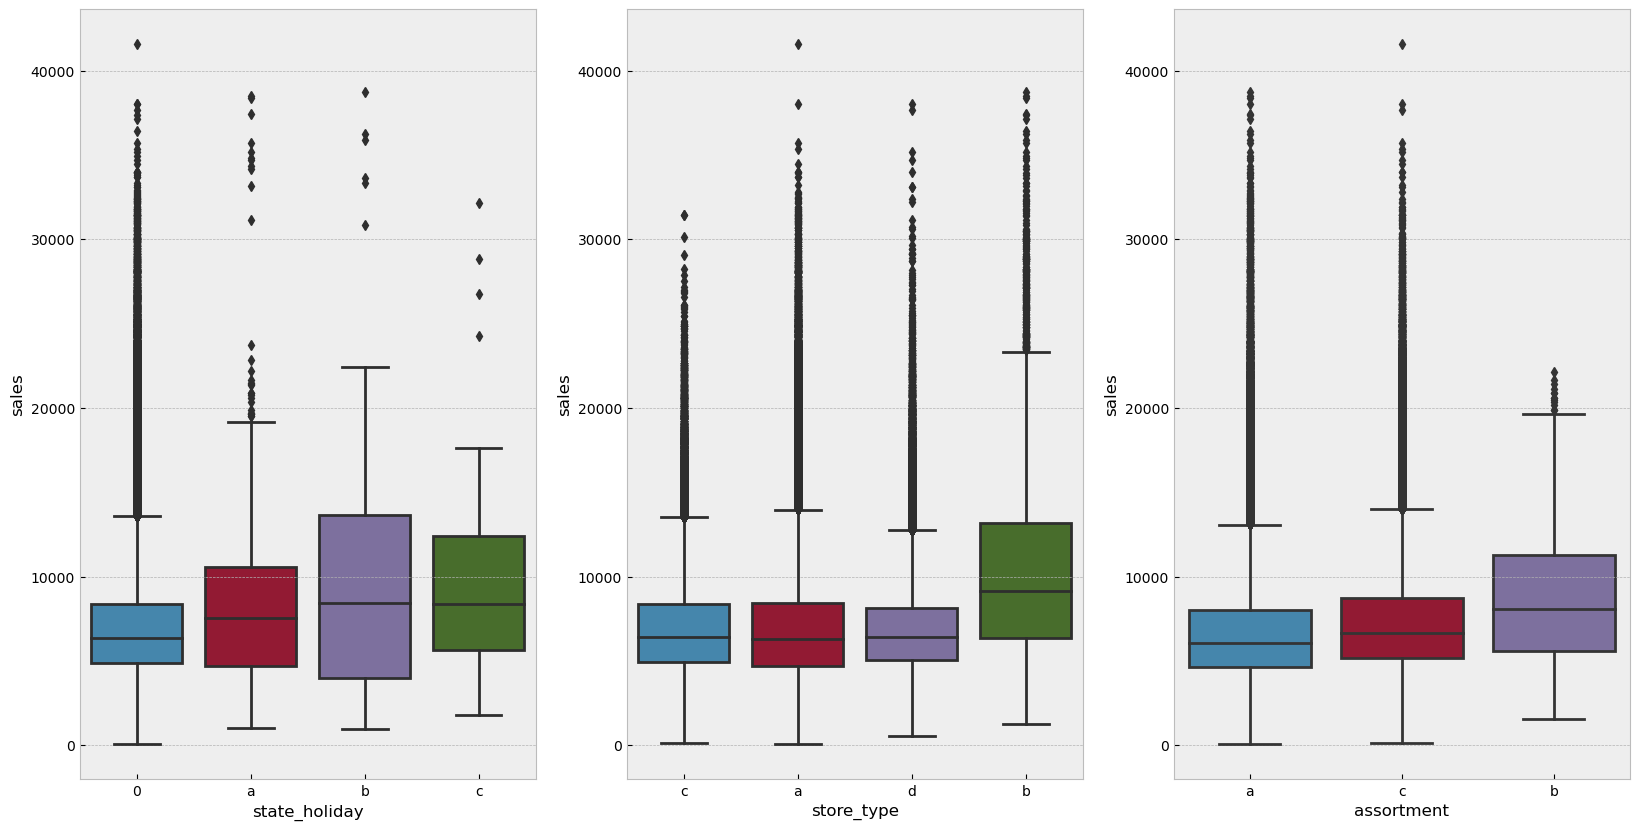

In [70]:
aux = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data= aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data= aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data= aux)


# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis Maps

In [13]:
Image('../img/MindMapHypothesis.png')

FileNotFoundError: No such file or directory: '../img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: '../img/MindMapHypothesis.png'

<IPython.core.display.Image object>

## 2.2 Creation of Hypotheses

### 2.2.1 Hypothesis Maps

1 - Stores with more employees should sell more.

2 - Stores with a larger inventory should sell more.

3 - Larger stores should sell more.

4 - Stores with closer competitors should sell less.

5 - Stores with a larger assortment should sell more.

6 - Stores with longer competitors should sell more.

### 2.2.2 Product's Hypothesis

1 - Stores opened during the holiday should sell more.

2 - Stores should sell more over the years

3 - Stores should sell more in the second half of the year.

4 - Stores should sell more after the 10th of each month.

5 - Stores should sell less on weekends.

6 - Stores should sell less during school holidays.

### 2.2.3 Time's Hypothesis

1 - Stores opened during the holiday should sell more.

2 - Stores should sell more over the years

3 - Stores should sell more in the second half of the year.

4 - Stores should sell more after the 10th of each month.

5 - Stores should sell less on weekends.

6 - Stores should sell less during school holidays.

## 2.3 Final Hypothesis

Store
1 - Stores with closer competitors should sell less.

2 - Stores with a larger assortment should sell more.

3 - Stores with longer competitors should sell more.

Products
4 - Stores with active promotions for longer should sell more.

5 - Stores with more promotion days should sell more.

6 - Stores with more consecutive promotions should sell more.

Time
7 - Stores open during the holiday should sell more.

8 - Stores should sell more over the years.

9 - Stores should sell more in the second half of the year.

10 - Stores should sell more after the 10th of each month.

11 - Stores should sell less on weekends.

12 - Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [71]:
df2 = df1.copy()

In [72]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month']= df2['date'].dt.month
# day 
df2['day']=df2['date'].dt.day

# week of year
df2['week_of_year']= df2['date'].dt.isocalendar().week

# # year week
df2['year_of_week']= df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7 ))
df2['promo_since_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#assortment
df2['assortment'] =df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

In [74]:
df2.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


# 3.0 VARIABLES FILTERING

In [ ]:
df3 = df2.copy()

In [80]:
df3.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [96]:
col_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(col_drop, axis = 1)

KeyError: "['customers', 'open', 'promo_interval', 'month_map'] not found in axis"

In [95]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_of_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_since_week'],
      dtype='object')

# 4.0 EXPLORATORY ANALYSIS

In [98]:
df4 = df3.copy()

## 4.1 Analysis Univariate

### 4.1.1 Response Variable

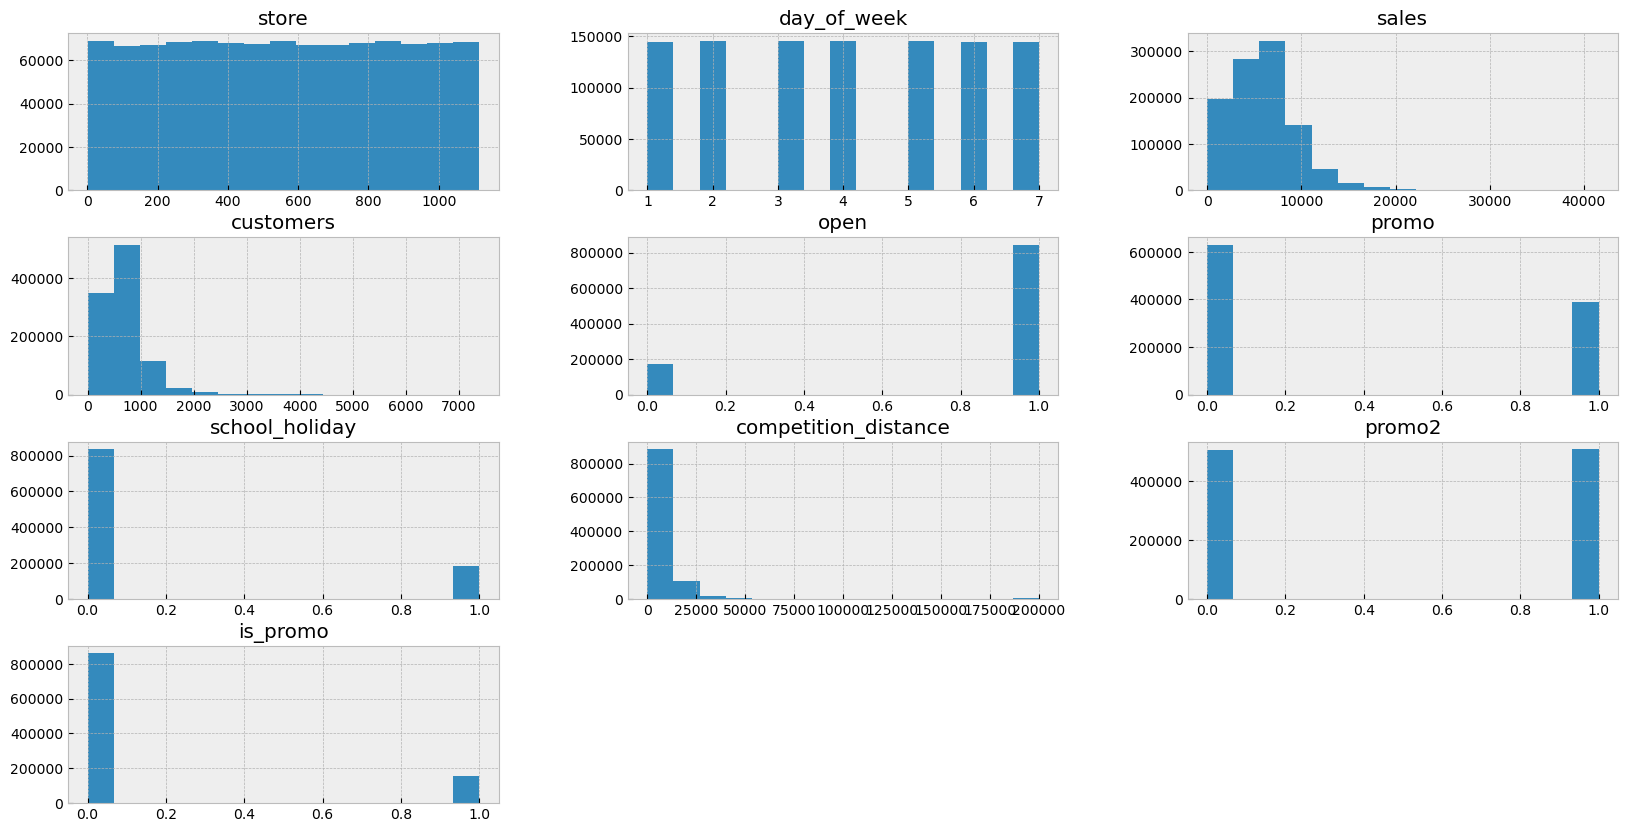

In [97]:
num_attributes.hist(bins=15);

<AxesSubplot:xlabel='sales', ylabel='Density'>

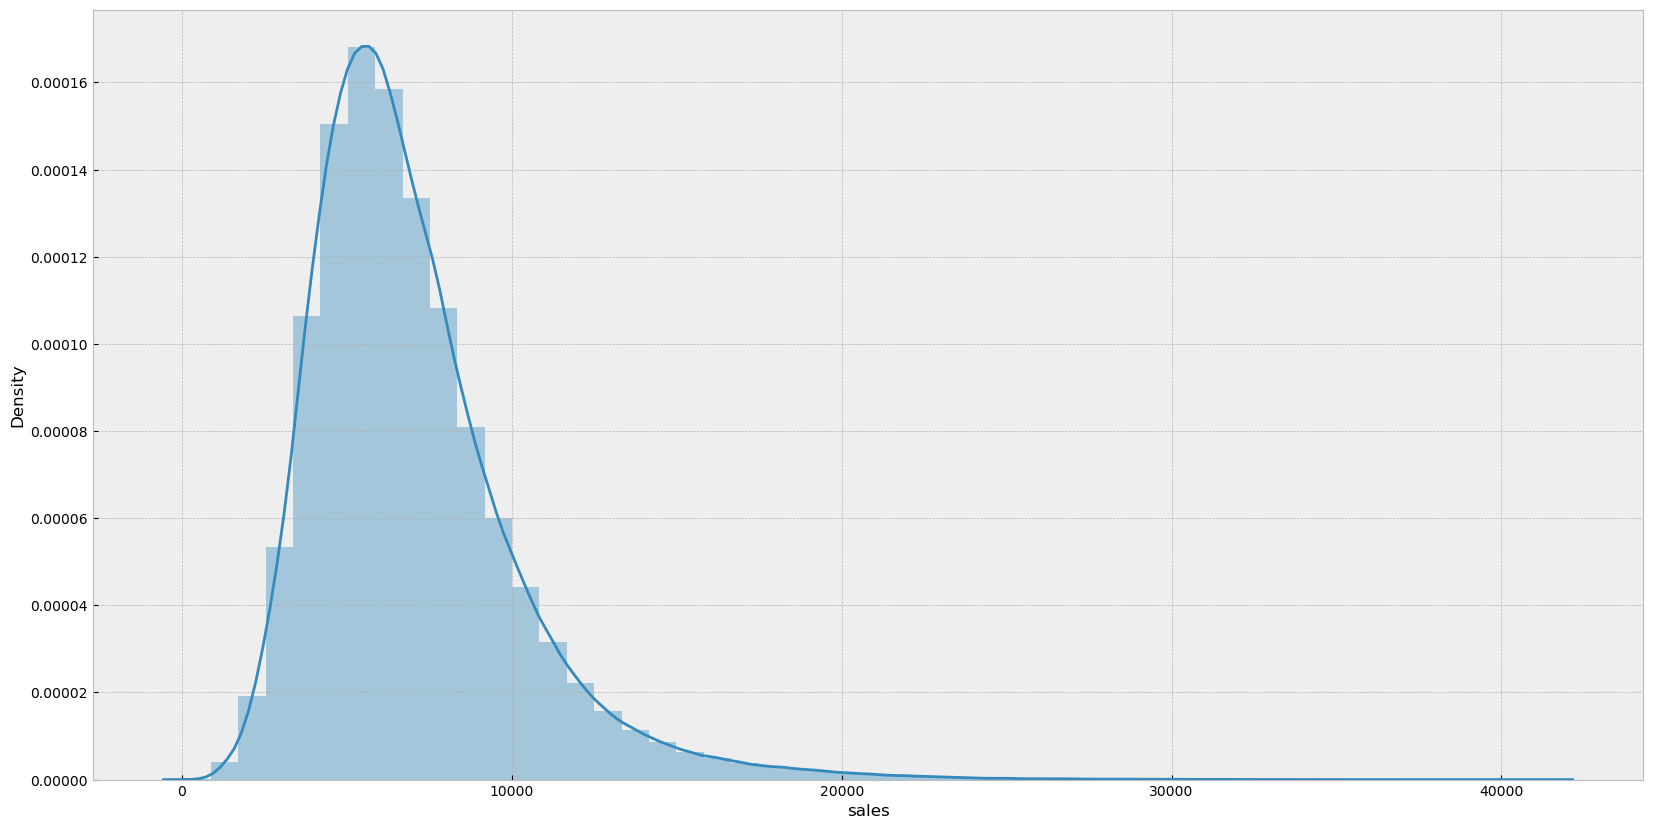

In [92]:
sns.distplot(df4['sales'], kde=True)

### 4.1.2 Numerical Variable

### 4.1.3 Categorical Variable

In [151]:
# Contar a quantidade de linhas dentro da variavel categorica 

df4['state_holiday'].drop_duplicates()

0           regular_day
1243     public holiday
76852    Easter holiday
76953         Christmas
Name: state_holiday, dtype: object

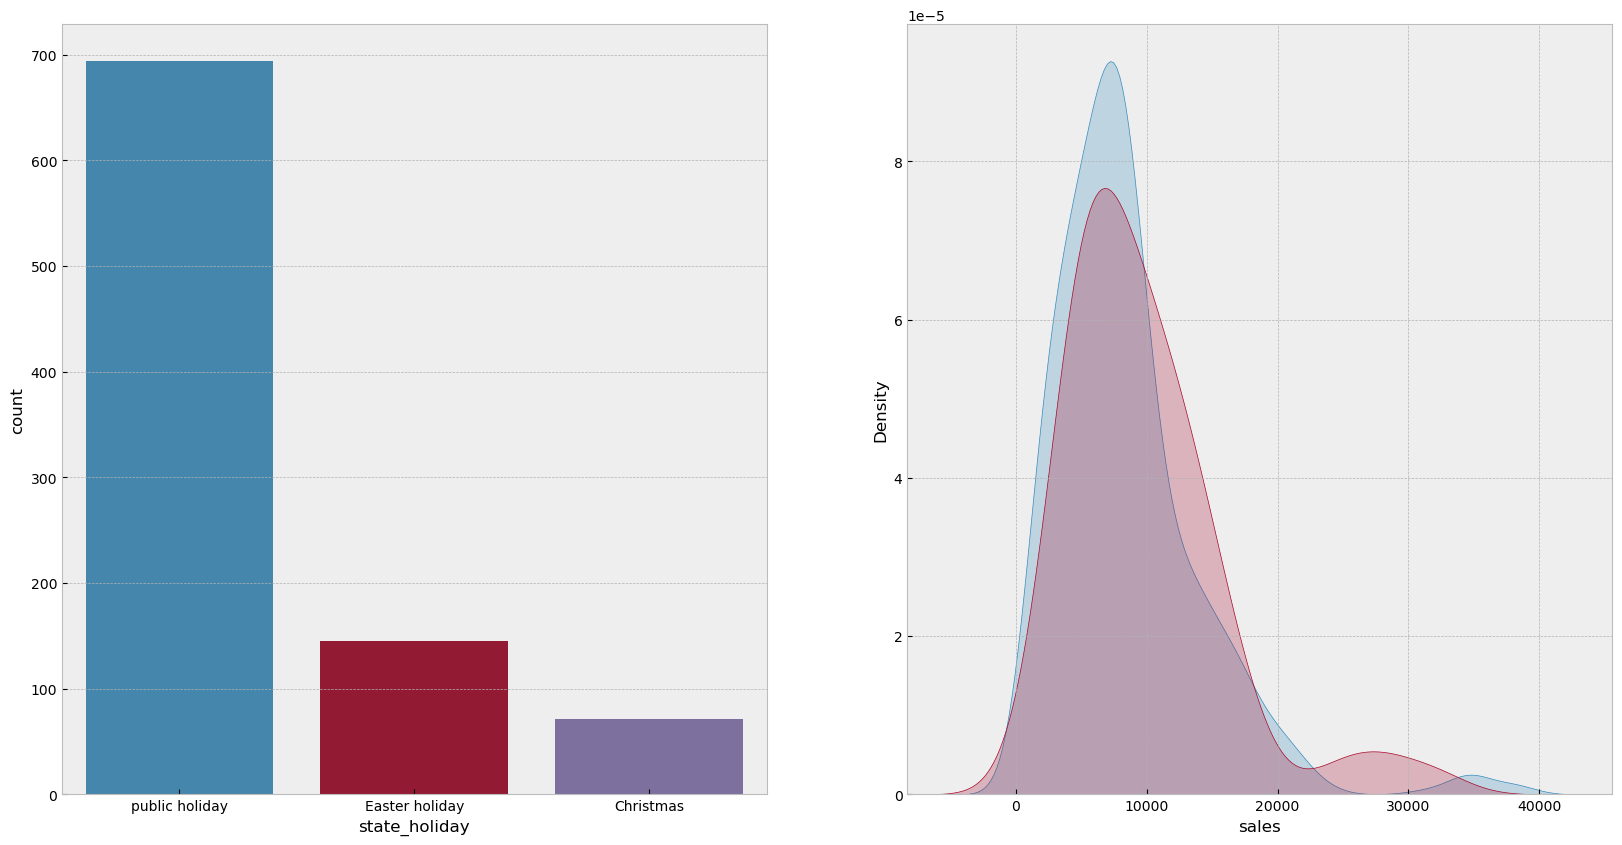

In [152]:
# state holiday 

a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
sns.countplot(a['state_holiday']);

plt.subplot(1, 2, 2)

sns.kdeplot(df4[df4['state_holiday'] == 'public holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter holiday']['sales'],label = 'easter_holiday',shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'],label = 'Christmas',shade = True);


In [156]:
df4['assortment'].drop_duplicates()

0            basic
2826      extended
234572       extra
Name: assortment, dtype: object

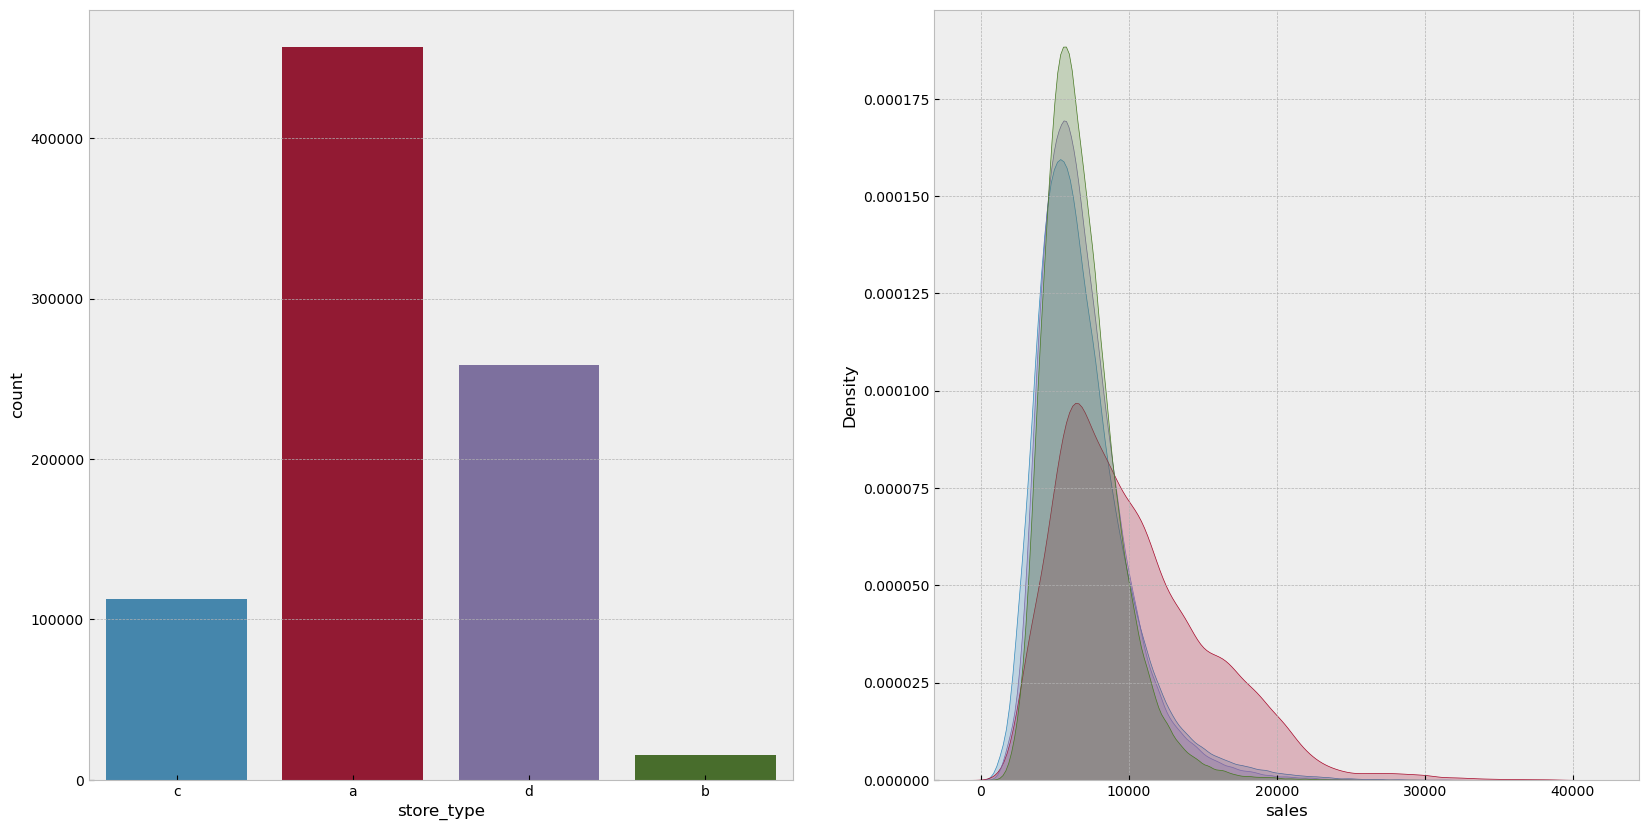

In [153]:
# store_type

plt.subplot(1, 2, 1)
sns.countplot(df4['store_type']);

plt.subplot(1, 2, 2)

sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b',shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c',shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd',shade = True);

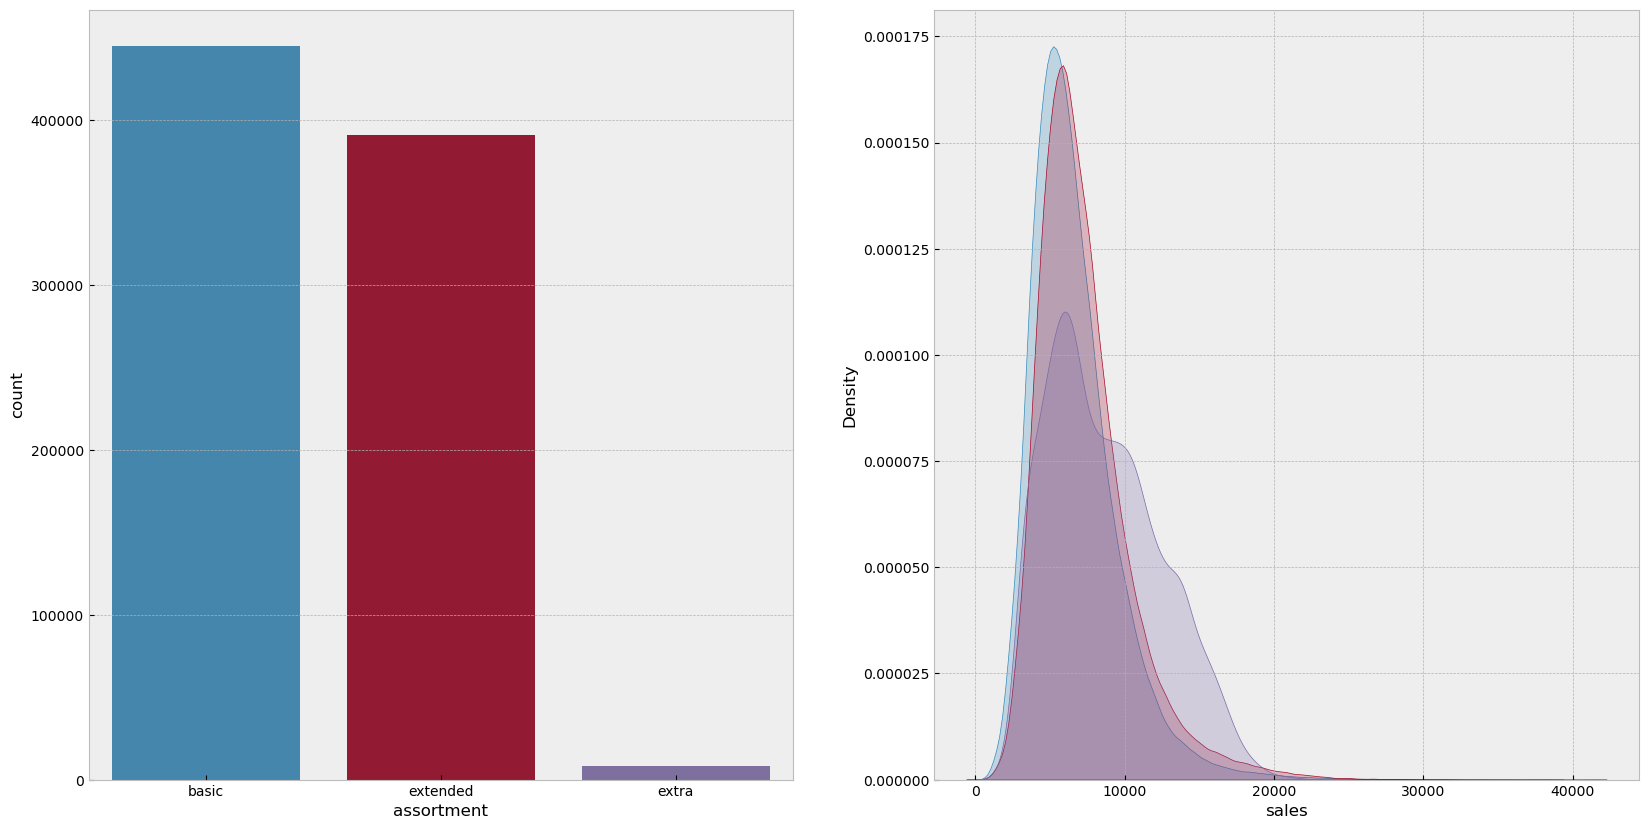

In [154]:
# assortment

plt.subplot(1, 2, 1)
sns.countplot(df4['assortment']);

plt.subplot(1, 2, 2)

sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extented',shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra',shade = True);
